# **Test on the capabilities of our model** 🏋

In [1]:
from model import *
from optax import adam
from src.datagen import Equations
import os
from jax import jit, vmap, random, lax
import jax
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scienceplots

jax.config.update("jax_enable_x64", True)
plt.style.use("science")

## Test the purely raw model

In [2]:
state_variables = 4
expected_number_of_nls = 4
input_dim = state_variables * expected_number_of_nls
output_dim = state_variables

model = ZeroLayersNN(N=input_dim, L=expected_number_of_nls, output_dim=state_variables)
seed = 42
train_batch_size = 32
test_batch_size = 64


dummy_input = jnp.zeros((train_batch_size, input_dim))
key = random.key(seed)
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
optimizer = adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)
print(
    f"There are {count_params(state.params['params'])} learnable parameters in the current architecture."
)

There are 92 learnable parameters in the current architecture.


Then we create the random non linearities:

- **generate_alphabeta**: This function generates orthonormal basis vectors using QR decomposition. It takes three parameters: `dim` (the dimension of the matrix), `num` (the number of basis vectors), and `seed` (a seed for random number generation). The function creates a random matrix `A` of shape `(dim, num)` and then performs QR decomposition on `A` to obtain an orthonormal matrix `Q`. The function returns `Q`.
- **generate_callable_functions**: This function generates a set of callable functions based on the orthonormal basis vectors generated by `generate_alphabeta`. It takes three parameters: `dim` (the dimension of the matrix), `num` (the number of functions to generate), and `seed` (a seed for random number generation). The function splits the basis vectors into three parts: `alphas`, `betas`, and `gammas`. It then defines a nested function `make_function` that creates a callable function using these vectors. The `make_function` uses JAX's `jit` decorator to compile the function for faster execution. The main function returns a tuple containing the generated functions and the transposed basis vectors.

In [3]:
def generate_alphabeta(dim, num, spread, seed):
    key = random.key(seed)
    shape = (dim, num)
    A = random.normal(key, shape)
    # Q, _, _ = jnp.linalg.svd(A, full_matrices=True)
    return A * spread


def generate_callable_functions(dim, num, spread, seed):
    bases = generate_alphabeta(dim, num, spread, seed)  # Get num basis vectors
    bases = bases.T
    alphas = bases[:, : dim // 2]  # First half of Q are alphas
    gammas = bases[:, dim // 2 :]

    def make_function(alpha, gamma):
        @jit
        def func(x):
            return (
                alpha[0] * nn.relu(x + gamma[0])
                + alpha[1] * nn.relu(x + gamma[1])
                + alpha[2] * nn.relu(x + gamma[2])
            )

        return func

    return tuple([make_function(alphas[i], gammas[i]) for i in range(num)]), bases

Now we want to work with the simplest case possible.


In [ ]:
dims = 6
n_nls = 4
spread = 5
alphagamma = generate_alphabeta(dims, n_nls, spread, seed)
alphagamma = alphagamma.T
alphas = alphagamma[:, : dims // 2].T  # First half of Q are alphas
gammas = alphagamma[:, dims // 2 :].T
print(alphagamma.shape)
print("Alphas:", alphas)
print("Gammas:", gammas)

non_lins, vec_nls = generate_callable_functions(dims, n_nls, spread, seed)

config = {
    "n_vars": state_variables,
    "n_eqs": state_variables,
    "bounds_addends": (1, 1),
    "bounds_multiplicands": (1, 1),
    "non_lins": non_lins,
    "sym_non_lins": None,
    "distribution": "uniform",
    "a": None,
    "b": None,
    "sigma": None,
    "p": None,
    "seed": seed,
}

(4, 6)
Alphas: [[-1.10193656 -1.51553843 -2.28166617]
 [-4.39734918  2.24324436 -1.02935378]
 [-4.47239829 -3.03186745  4.60982899]
 [-1.26942404  0.83381083  4.52596135]]
Gammas: [[ 1.37503869 -5.26811309 -9.21461028]
 [-6.93446749  6.72467578 -0.60287698]
 [-4.69652958 -0.83694919  7.00154973]
 [-0.33196753  5.30788252 -3.36975958]]


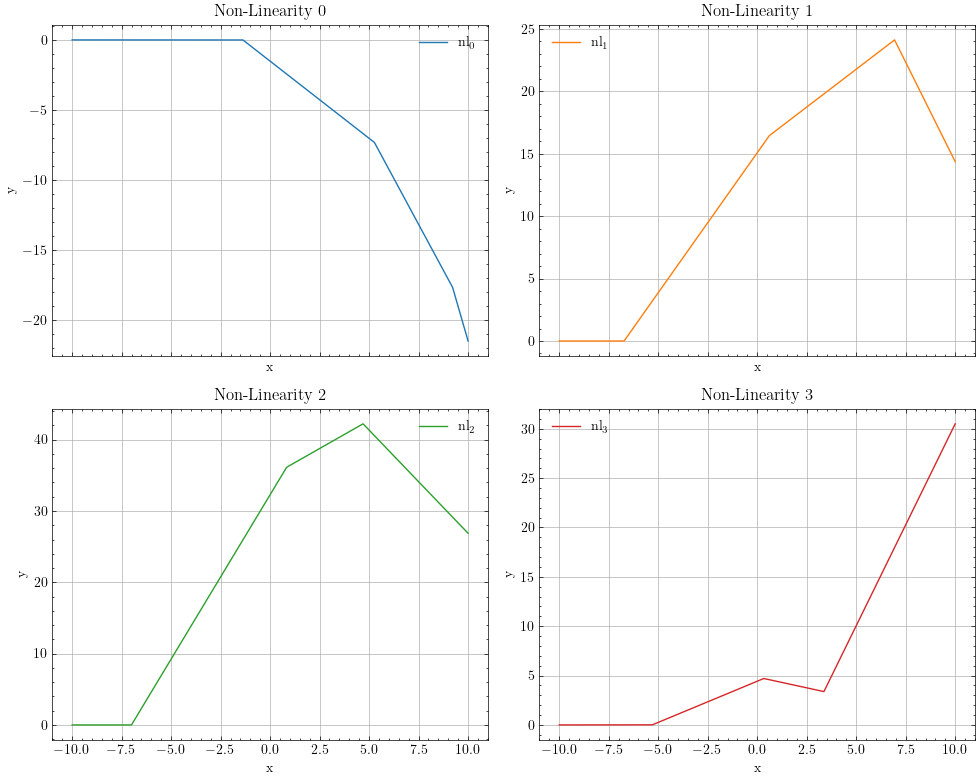

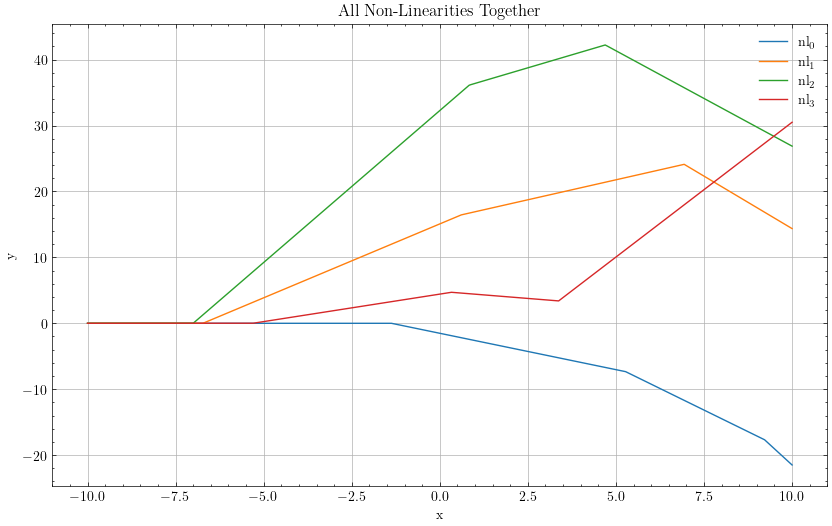

In [5]:
# Create subplots for individual non-linearities
num_funcs = len(non_lins)
cols = 2  # Number of columns in the grid
rows = (num_funcs + 1) // cols  # Rows for individual plots
fig, axes = plt.subplots(rows, cols, figsize=(10, 8), sharex=True)

x = jnp.linspace(-10, 10, 1000)
colors = plt.cm.tab10(range(num_funcs))  # Use a colormap to assign colors

# Plot each callable's result in separate subplots
for i, func in enumerate(non_lins):
    row, col = divmod(i, cols)
    ax = axes[row, col]
    y = func(x)
    ax.plot(x, y, label=r"$\text{nl}_{%d}$" % i, color=colors[i])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Non-Linearity {i}")
    ax.legend()
    ax.grid(True)

# Adjust layout for individual plots
plt.tight_layout()
plt.show()
plt.clf()
plt.close()

# Create a separate figure for all non-linearities together
plt.figure(figsize=(10, 6))
for i, func in enumerate(non_lins):
    y = func(x)
    plt.plot(x, y, label=r"$\text{nl}_{%d}$" % i, color=colors[i])
plt.xlabel("x")
plt.ylabel("y")
plt.title("All Non-Linearities Together")
plt.legend()
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [6]:
system = Equations(config)
system.save_symb_expr()

System and state loaded from equations_5a837b5e29275248798ed0de864b5a13.pkl
PDF already exists


### Linspace

Let's try to train the model with data sampled by linspace. The test set is taken out of bounds with respect to the training data, in such way it is possible to verify the generalization abilities of the model.

In [7]:
def my_eval(v):
    return system(y=v)

In [8]:
bound = 15
train_size = int(1e4)
test_ratio = 0.2
test_size = int(test_ratio * train_size)
total_size = train_size + test_size
train_values = jnp.tile(
    jnp.linspace(-1 * bound, bound, total_size).reshape(-1, 1), (1, config["n_eqs"])
)

# Randomly select `test_size` elements for inbound_test
key = random.key(seed)
key, subkey = random.split(key)  # Ensure reproducibility
indices = random.choice(
    subkey, total_size, shape=(test_size,), replace=False
)  # Unique indices
inbound_test = train_values[indices]  # Extract test points
mask = jnp.ones(total_size, dtype=bool)
mask = mask.at[indices].set(False)  # Mask out test points
train_values = train_values[mask]  # Remove test points from training set

# Create out-of-bound test values
range1 = jnp.linspace(-1 * bound - 5, -1 * bound, test_size // 2)
range2 = jnp.linspace(bound, bound + 5, test_size // 2)
outofbound_test = jnp.concatenate((range1, range2), axis=0).reshape(-1, 1)
outofbound_test = jnp.tile(outofbound_test, (1, config["n_eqs"]))

# Stack both test sets
stacked_test = jnp.vstack((inbound_test, outofbound_test))

# Concatenate train and test values
values = jnp.vstack((train_values, stacked_test))

# Standardize values
values_mean = jnp.mean(values, axis=0)
values_std = jnp.std(values, axis=0)


# Evaluate
evaluated_values = vmap(my_eval)(values)
values = (values - values_mean) / values_std

# Standardize evaluated_values
evaluated_values_mean = jnp.mean(evaluated_values, axis=0)
evaluated_values_std = jnp.std(evaluated_values, axis=0)
evaluated_values = (evaluated_values - evaluated_values_mean) / evaluated_values_std

In [9]:
print(train_values.shape, inbound_test.shape, outofbound_test.shape)

(10000, 4) (2000, 4) (2000, 4)


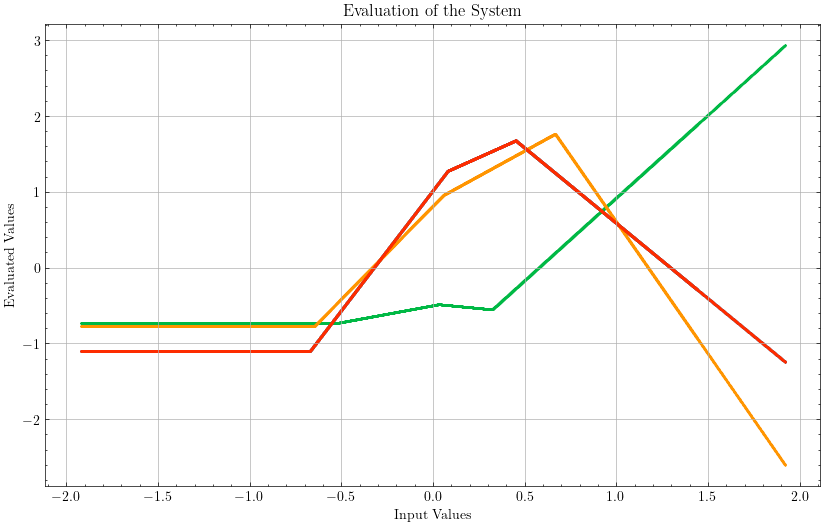

In [10]:
plt.figure(figsize=(10, 6))
for i in range(config["n_eqs"]):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f"Equation {i+1}", s=0.1)
plt.xlabel("Input Values")
plt.ylabel("Evaluated Values")
plt.title("Evaluation of the System")
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [11]:
expanded_values = jnp.repeat(values, expected_number_of_nls, axis=1)
train_values = expanded_values[:train_size]
inbound_test = expanded_values[train_size : test_size + train_size]
outofbound_test = expanded_values[test_size + train_size :]

train_outputs, inbound_test_outputs = (
    evaluated_values[:train_size],
    evaluated_values[train_size : test_size + train_size],
)
outofbound_test_outputs = evaluated_values[test_size + train_size :]

train_batches = create_batches(train_values, train_outputs, train_batch_size)
inbound_test_batches = create_batches(
    inbound_test, inbound_test_outputs, test_batch_size
)
outofbound_test_batches = create_batches(
    outofbound_test, outofbound_test_outputs, test_batch_size
)

In [12]:
print(train_values.shape, inbound_test.shape, outofbound_test.shape)
print(train_outputs.shape, inbound_test_outputs.shape, outofbound_test_outputs.shape)
print(len(train_batches), len(inbound_test_batches), len(outofbound_test_batches))
print(
    len(train_batches),
    len(train_batches[0]),
    len(train_batches[0][0]),
    len(train_batches[0][0][0]),
    len(train_batches[1][0][0]),
)
print(
    len(inbound_test_batches),
    len(inbound_test_batches[0]),
    len(inbound_test_batches[0][0]),
    len(inbound_test_batches[0][0][0]),
    len(inbound_test_batches[1][0][0]),
)
print(
    len(outofbound_test_batches),
    len(outofbound_test_batches[0]),
    len(outofbound_test_batches[0][0]),
    len(outofbound_test_batches[0][0][0]),
    len(outofbound_test_batches[1][0][0]),
)
print(
    type(train_batches[0]),
    type(train_batches[0][0]),
    type(train_batches[0][0][0]),
    type(train_batches[0][0][0][0]),
    type(train_batches[0][1][0]),
)

(10000, 16) (2000, 16) (2000, 16)
(10000, 4) (2000, 4) (2000, 4)
2 2 2
2 312 32 16 4
2 31 64 16 4
2 31 64 16 4
<class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'> <class 'jaxlib.xla_extension.ArrayImpl'>


In [13]:
vectors = jnp.concatenate(
    (
        state.params["params"]["CustomActivation_0"]["alpha"],
        state.params["params"]["CustomActivation_0"]["gamma"],
    ),
    axis=0,
).T
print(vectors)

[[ 1.73519436e-02  1.00111278e-02  1.12957067e-02  7.25720915e-03
  -2.52636361e-02  2.19562402e-02]
 [-6.41544195e-03 -2.83256410e-03 -1.25704000e-05 -2.57506505e-02
  -1.11750940e-02  8.40582724e-03]
 [-1.91145488e-03 -5.80547155e-03  1.72669902e-02 -6.27535779e-03
   1.23177065e-02  2.81345274e-03]
 [-1.89821876e-03  2.20581762e-03  7.13649648e-03 -5.02077212e-03
  -2.25755262e-03 -1.36418752e-02]]


In [14]:
@partial(jit, static_argnums=1)
def loss_fn(params, apply_fn, batch_x, batch_y):
    predictions = apply_fn(params, batch_x)
    return jnp.mean((predictions - batch_y) ** 2)

In [15]:
num_epochs = 201


@jit
def train_epoch(carry, epoch):
    state, _ = carry  # Unpack state and dummy loss accumulator
    epoch_loss = jnp.array(0.0)

    # Loop over batches
    def batch_step(carry, batch):
        state, _ = carry
        batch_x, batch_y = batch
        state, train_loss = train_step(state, batch_x, batch_y, loss_fn)
        inbound_test_loss = evaluate(state, inbound_test_batches, loss_fn)
        outofbound_test_loss = evaluate(state, outofbound_test_batches, loss_fn)

        return (state, train_loss), (
            train_loss,
            inbound_test_loss,
            outofbound_test_loss,
        )

    (state, _), (train_losses, inbound_test_losses, outofbound_test_losses) = lax.scan(
        batch_step, (state, 0.0), train_batches
    )

    # Print every n epochs
    print_condition = epoch % 5 == 0
    jax.lax.cond(
        print_condition,
        # True branch: print metrics
        lambda: jax.debug.print(
            "Epoch: {epoch}, Train Loss: {train_loss:.4e}, Inbound-Test Loss: {inbound_test_loss:.4e}, Outofbound-Test Loss: {outofbound_test_loss:.4e} ",
            epoch=epoch,
            train_loss=jnp.mean(train_losses),
            inbound_test_loss=jnp.mean(inbound_test_losses),
            outofbound_test_loss=jnp.mean(outofbound_test_losses),
        ),
        # False branch: do nothing
        lambda: None,
    )
    return (state, epoch_loss), (
        train_losses,
        inbound_test_losses,
        outofbound_test_losses,
    )


start_time = time.time()
(state, loss), (train_losses, inbound_test_losses, outofbound_test_losses) = lax.scan(
    train_epoch, (state, 0.0), jnp.arange(num_epochs)
)
jax.block_until_ready(state)
print("Training complete!")
end_time = time.time()
print(f"Total training time: {end_time - start_time:.4f} seconds")

Epoch: 0, Train Loss: 2.1052e-02, Inbound-Test Loss: 3.1705e-01, Outofbound-Test Loss: 1.1333e+00 
Epoch: 5, Train Loss: 1.2402e-02, Inbound-Test Loss: 1.9190e-01, Outofbound-Test Loss: 1.2095e+00 
Epoch: 10, Train Loss: 4.2797e-04, Inbound-Test Loss: 6.6271e-03, Outofbound-Test Loss: 3.1084e-02 
Epoch: 15, Train Loss: 4.2032e-04, Inbound-Test Loss: 6.5128e-03, Outofbound-Test Loss: 2.9079e-02 
Epoch: 20, Train Loss: 4.1102e-04, Inbound-Test Loss: 6.3779e-03, Outofbound-Test Loss: 2.7682e-02 
Epoch: 25, Train Loss: 3.8278e-04, Inbound-Test Loss: 5.9357e-03, Outofbound-Test Loss: 2.4700e-02 
Epoch: 30, Train Loss: 2.1441e-04, Inbound-Test Loss: 3.2874e-03, Outofbound-Test Loss: 1.3680e-02 
Epoch: 35, Train Loss: 1.0120e-04, Inbound-Test Loss: 1.5685e-03, Outofbound-Test Loss: 3.5508e-03 
Epoch: 40, Train Loss: 4.7037e-05, Inbound-Test Loss: 7.1162e-04, Outofbound-Test Loss: 1.3692e-03 
Epoch: 45, Train Loss: 2.9637e-05, Inbound-Test Loss: 4.4480e-04, Outofbound-Test Loss: 5.2479e-04 
Ep

In [16]:
plot_step = 1  # Adjust this value as needed
train_losses = train_losses.flatten()
inbound_test_losses = inbound_test_losses.flatten()
outofbound_test_losses = outofbound_test_losses.flatten()

# Generate steps for plotting
train_steps = jnp.arange(len(train_losses))[::plot_step]

train_plot = jnp.array(train_losses[::plot_step]).copy()
inbound_test_plot = jnp.array(inbound_test_losses[::plot_step]).copy()
outofbound_test_plot = jnp.array(outofbound_test_losses[::plot_step]).copy()

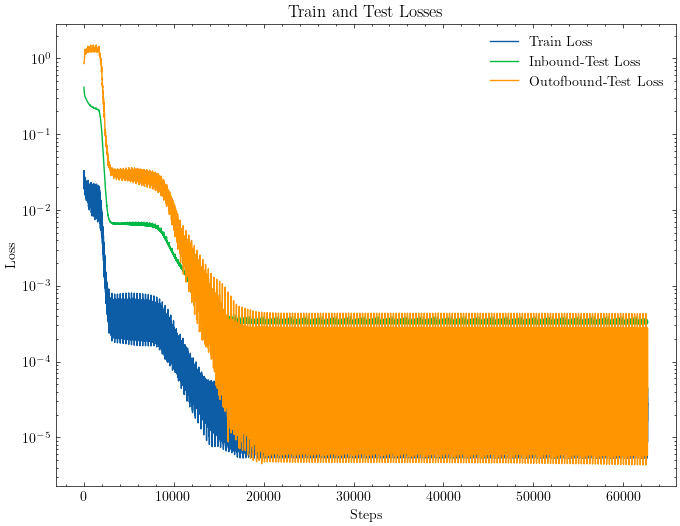

<Figure size 350x262.5 with 0 Axes>

In [17]:
# Plot the losses
plt.figure(figsize=(8, 6))
plt.plot(train_steps, train_plot, label="Train Loss", linewidth=1)
plt.plot(train_steps, inbound_test_plot, label="Inbound-Test Loss", linewidth=1)
plt.plot(train_steps, outofbound_test_plot, label="Outofbound-Test Loss", linewidth=1)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.yscale("log")
plt.title("Train and Test Losses")
plt.show()
plt.close()
plt.clf()

In [18]:
vectors = jnp.concatenate(
    (
        state.params["params"]["CustomActivation_0"]["alpha"],
        state.params["params"]["CustomActivation_0"]["gamma"],
    ),
    axis=0,
).T
print(vectors)

[[ 0.28421088  0.2314483   0.30292017  0.6639897   0.66391149  0.66400977]
 [-0.73715291  0.17366765  0.22196387 -0.68586613  0.65993433  0.66251341]
 [-0.36282958 -0.6113825  -0.59640734 -0.41165394 -0.08458498 -0.46275487]
 [ 0.27124753  0.28598767  0.26484966  0.68477292  0.6854775   0.68464636]]


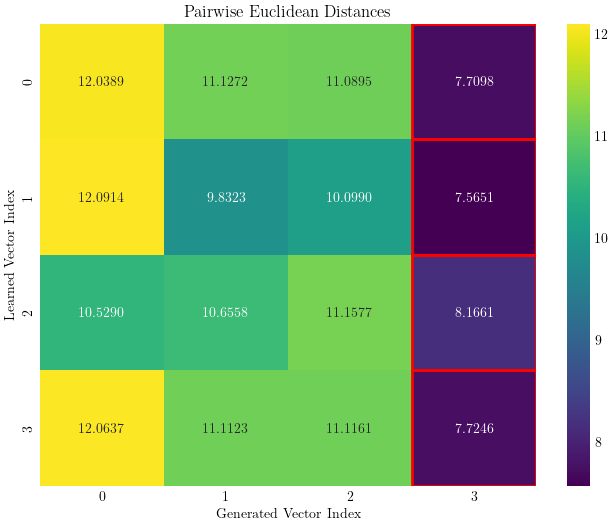

In [19]:
# Set ticks length to zero
plt.rcParams["xtick.minor.size"] = 0
plt.rcParams["ytick.minor.size"] = 0
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0

pairwise_distances = jnp.sqrt(
    jnp.sum((vectors[:, None, :] - vec_nls[None, :, :]) ** 2, axis=-1)
)
min_indices = jnp.argmin(pairwise_distances, axis=1)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(pairwise_distances, annot=True, fmt=".4f", cmap="viridis", cbar=True)

# Highlight the minimum value in each row with a red border
for i, min_idx in enumerate(min_indices):
    ax.add_patch(plt.Rectangle((min_idx, i), 1, 1, fill=False, edgecolor="red", lw=2))

# Add labels and title
plt.xlabel("Generated Vector Index")
plt.ylabel("Learned Vector Index")
plt.title("Pairwise Euclidean Distances")
plt.show()
plt.clf()
plt.close()

plt.rcParams.update(plt.rcParamsDefault)
plt.style.use("science")

[Array(2, dtype=int64), Array(3, dtype=int64), Array(2, dtype=int64), Array(2, dtype=int64)]


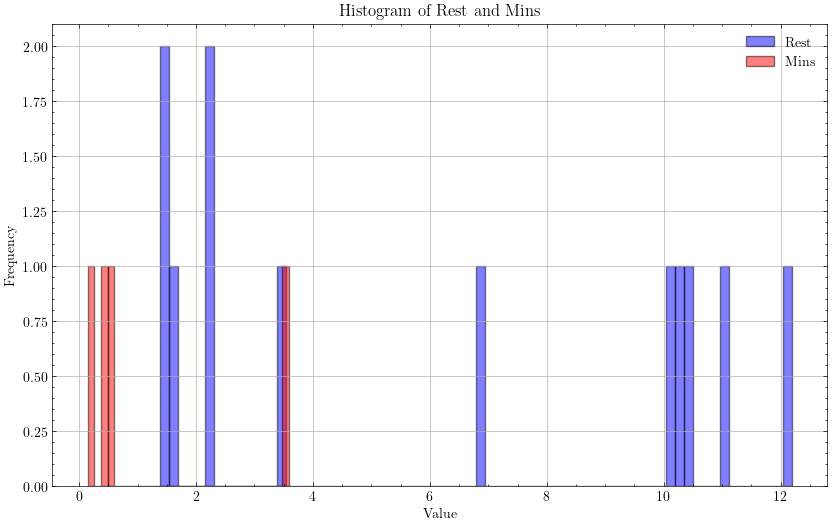

In [20]:
rest = []
mins = []
mins_nls = []

for vec in vectors:
    temp = []
    for nls in vec_nls:
        temp.append(jnp.abs(vec @ nls))

    min_value = jnp.min(jnp.array(temp))
    min_index = jnp.argmin(jnp.array(temp))  # Find the index of the minimum value

    mins.append(min_value)
    mins_nls.append(min_index)  # Store the `nls` corresponding to the minimum value

    # Remove the min value and associated nls
    temp.remove(min_value)
    rest.append(temp)

print(mins_nls)

plt.figure(figsize=(10, 6))
plt.hist(
    [item for sublist in rest for item in sublist],
    bins=70,
    edgecolor="black",
    alpha=0.5,
    label="Rest",
    color="blue",
)
plt.hist(mins, bins=30, edgecolor="black", alpha=0.5, label="Mins", color="red")
plt.title("Histogram of Rest and Mins")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

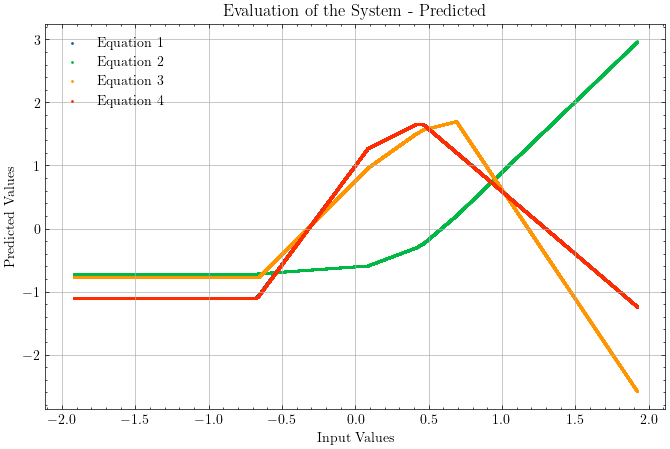

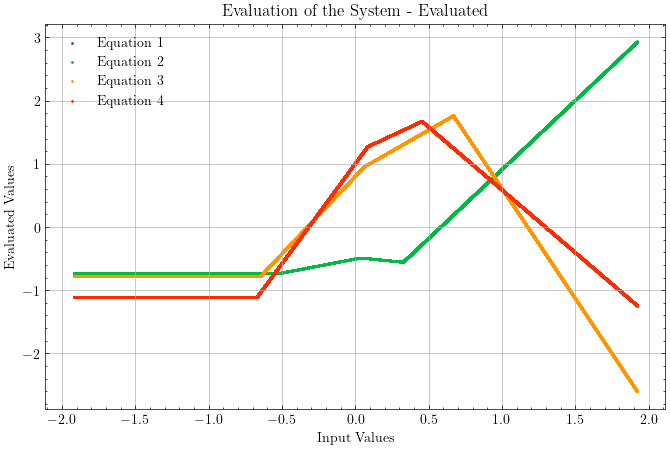

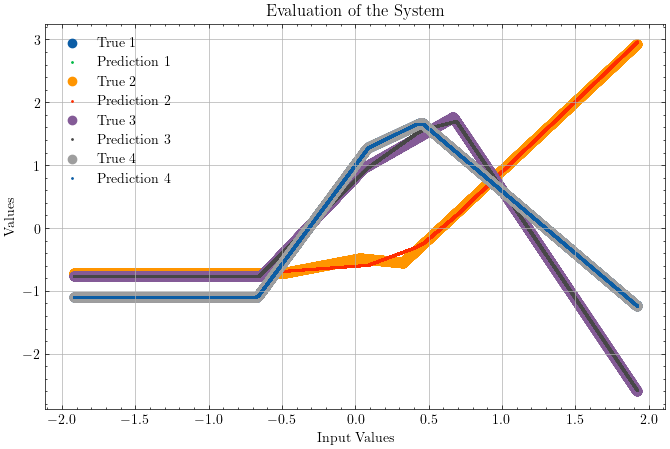

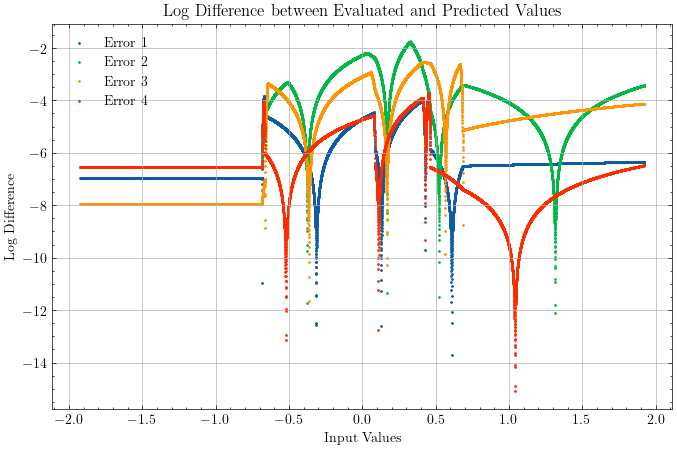

In [21]:
predicted_values = state.apply_fn(state.params, expanded_values)

plt.figure(figsize=(8, 5))
for i in range(config["n_eqs"]):
    plt.scatter(values[:, i], predicted_values[:, i], label=f"Equation {i+1}", s=1)
plt.xlabel("Input Values")
plt.ylabel("Predicted Values")
plt.title("Evaluation of the System - Predicted")
plt.grid(True)
if config["n_eqs"] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config["n_eqs"]):
    plt.scatter(values[:, i], evaluated_values[:, i], label=f"Equation {i+1}", s=1)
plt.xlabel("Input Values")
plt.ylabel("Evaluated Values")
plt.title("Evaluation of the System - Evaluated")
plt.grid(True)
if config["n_eqs"] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config["n_eqs"]):
    plt.scatter(values[:, i], evaluated_values[:, i], label=f"True {i+1}")
    plt.scatter(values[:, i], predicted_values[:, i], label=f"Prediction {i+1}", s=1)
plt.xlabel("Input Values")
plt.ylabel("Values")
plt.title("Evaluation of the System")
plt.grid(True)
if config["n_eqs"] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config["n_eqs"]):
    plt.scatter(
        values[:, i],
        jnp.log(jnp.abs(evaluated_values[:, i] - predicted_values[:, i]) + 1e-7),
        label=f"Error {i+1}",
        s=1,
    )
plt.xlabel("Input Values")
plt.ylabel("Log Difference")
plt.title("Log Difference between Evaluated and Predicted Values")
plt.grid(True)
if config["n_eqs"] < 10:
    plt.legend()
plt.show()

plt.clf()
plt.close()

In [22]:
print(state.params["params"]["Dense_0"]["kernel"])
print(vec_nls)
print(vectors)

[[ 0.34512708  0.17862242  0.34122667  0.24935648]
 [ 0.05330795  0.07778742  1.2578838  -0.542919  ]
 [ 0.6578116  -0.26289666 -0.02152767  0.5314533 ]
 [ 0.52210945  0.25141168  0.22814764  0.40330955]
 [ 0.407691    0.1283828  -0.270215    0.57674265]
 [ 0.08902893 -0.13964334  1.5544379  -0.14131777]
 [ 0.92275774 -0.26688966  0.29050523  0.7377724 ]
 [ 0.77028066  0.00881908 -0.09132674  0.9375206 ]
 [ 0.7508545  -0.13315146  0.4949703   0.699812  ]
 [ 0.05989814 -0.2712304   1.3398042   0.29613316]
 [ 0.74277306 -0.42087024  0.33682713  1.0894563 ]
 [ 0.38835248 -0.04711486 -0.06541679  0.21200795]
 [ 0.06525483 -0.34907046 -0.3551771   0.66355306]
 [-0.17603967 -0.0149532   1.3589281   0.39074063]
 [ 0.9233485  -0.20194954  0.49903893  0.90578246]
 [ 0.55572224  0.33330578 -0.1035661   0.09177516]]
[[-1.10193656 -1.51553843 -2.28166617  1.37503869 -5.26811309 -9.21461028]
 [-4.39734918  2.24324436 -1.02935378 -6.93446749  6.72467578 -0.60287698]
 [-4.47239829 -3.03186745  4.6098

### Uniform

In [23]:
del system, values, evaluated_values
system = Equations(config)

System and state loaded from equations_5a837b5e29275248798ed0de864b5a13.pkl


In [24]:
# Split random key
key, subkey = random.split(key)

# Generate new training values uniformly in [-bound, bound]
train_values = random.uniform(
    subkey, shape=(total_size, config["n_vars"]), minval=-1 * bound, maxval=bound
)

inbound_test = train_values[indices]  # Extract test points
train_values = train_values[mask]  # Remove them from training set

# Generate out-of-bound test values in [-bound-bound_delta, -bound] ∪ [bound, bound+bound_delta]
bound_delta = 5
key, subkey = random.split(key)
range1 = random.uniform(
    subkey,
    shape=(test_size // 2, config["n_vars"]),
    minval=-1 * bound - bound_delta,
    maxval=-1 * bound,
)
key, subkey = random.split(key)
range2 = random.uniform(
    subkey,
    shape=(test_size // 2, config["n_vars"]),
    minval=bound,
    maxval=bound + bound_delta,
)
outofbound_test = jnp.concatenate((range1, range2), axis=0)

# Stack both test sets
stacked_test = jnp.vstack((inbound_test, outofbound_test))

# Concatenate training and test values
values = jnp.vstack((train_values, stacked_test))

# Standardize values
values_mean = jnp.mean(values, axis=0)
values_std = jnp.std(values, axis=0)


# Evaluate
evaluated_values = vmap(my_eval)(values)
values = (values - values_mean) / values_std

# Standardize evaluated_values
evaluated_values_mean = jnp.mean(evaluated_values, axis=0)
evaluated_values_std = jnp.std(evaluated_values, axis=0)
evaluated_values = (evaluated_values - evaluated_values_mean) / evaluated_values_std

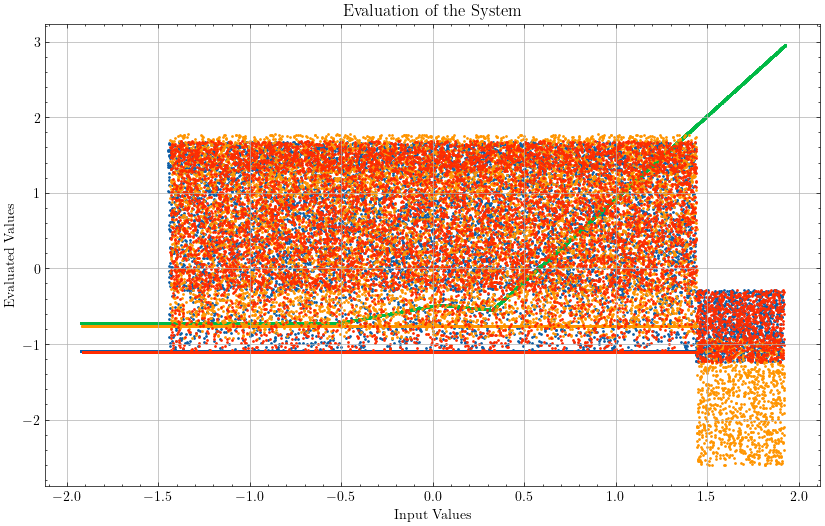

In [25]:
plt.figure(figsize=(10, 6))
for i in range(config["n_eqs"]):
    plt.scatter(values[:, i], evaluated_values[:, i], label=f"Equation {i+1}", s=1)
plt.xlabel("Input Values")
plt.ylabel("Evaluated Values")
plt.title("Evaluation of the System")
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [26]:
expanded_values = jnp.repeat(values, expected_number_of_nls, axis=1)
train_values = expanded_values[:train_size]
inbound_test = expanded_values[train_size : test_size + train_size]
outofbound_test = expanded_values[test_size + train_size :]

train_outputs, inbound_test_outputs = (
    evaluated_values[:train_size],
    evaluated_values[train_size : test_size + train_size],
)
outofbound_test_outputs = evaluated_values[test_size + train_size :]

train_batches = create_batches(train_values, train_outputs, train_batch_size)
inbound_test_batches = create_batches(
    inbound_test, inbound_test_outputs, test_batch_size
)
outofbound_test_batches = create_batches(
    outofbound_test, outofbound_test_outputs, test_batch_size
)

In [27]:
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [28]:
num_epochs = 201

start_time = time.time()
(state, loss), (train_losses, inbound_test_losses, outofbound_test_losses) = lax.scan(
    train_epoch, (state, 0.0), jnp.arange(num_epochs)
)
jax.block_until_ready(state)
print("Training complete!")
end_time = time.time()
print(f"Total training time: {end_time - start_time:.4f} seconds")

Epoch: 0, Train Loss: 2.1160e-02, Inbound-Test Loss: 3.1900e-01, Outofbound-Test Loss: 1.1546e+00 
Epoch: 5, Train Loss: 6.9019e-04, Inbound-Test Loss: 1.0579e-02, Outofbound-Test Loss: 5.5748e-02 
Epoch: 10, Train Loss: 4.1521e-04, Inbound-Test Loss: 6.4353e-03, Outofbound-Test Loss: 2.8754e-02 
Epoch: 15, Train Loss: 4.0872e-04, Inbound-Test Loss: 6.3454e-03, Outofbound-Test Loss: 2.7185e-02 
Epoch: 20, Train Loss: 3.9680e-04, Inbound-Test Loss: 6.1560e-03, Outofbound-Test Loss: 2.5547e-02 
Epoch: 25, Train Loss: 3.1099e-04, Inbound-Test Loss: 4.8209e-03, Outofbound-Test Loss: 2.0013e-02 
Epoch: 30, Train Loss: 1.5336e-04, Inbound-Test Loss: 2.3353e-03, Outofbound-Test Loss: 7.3848e-03 
Epoch: 35, Train Loss: 7.5642e-05, Inbound-Test Loss: 1.1551e-03, Outofbound-Test Loss: 2.3619e-03 
Epoch: 40, Train Loss: 4.0727e-05, Inbound-Test Loss: 6.1938e-04, Outofbound-Test Loss: 9.7257e-04 
Epoch: 45, Train Loss: 2.9937e-05, Inbound-Test Loss: 4.5334e-04, Outofbound-Test Loss: 4.6898e-04 
Ep

In [29]:
plot_step = 1  # Adjust this value as needed
train_losses = train_losses.flatten()
inbound_test_losses = inbound_test_losses.flatten()
outofbound_test_losses = outofbound_test_losses.flatten()

# Generate steps for plotting
train_steps = jnp.arange(len(train_losses))[::plot_step]

train_plot = jnp.array(train_losses[::plot_step]).copy()
inbound_test_plot = jnp.array(inbound_test_losses[::plot_step]).copy()
outofbound_test_plot = jnp.array(outofbound_test_losses[::plot_step]).copy()

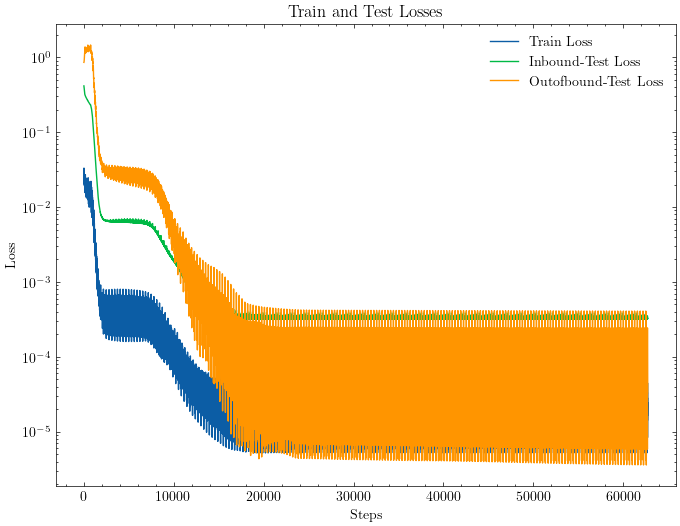

In [30]:
# Plot the losses
plt.figure(figsize=(8, 6))
plt.plot(train_steps, train_plot, label="Train Loss", linewidth=1)
plt.plot(train_steps, inbound_test_plot, label="Inbound-Test Loss", linewidth=1)
plt.plot(train_steps, outofbound_test_plot, label="Outofbound-Test Loss", linewidth=1)
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.yscale("log")
plt.title("Train and Test Losses")
plt.show()
plt.close()
plt.clf()

<Figure size 350x262.5 with 0 Axes>

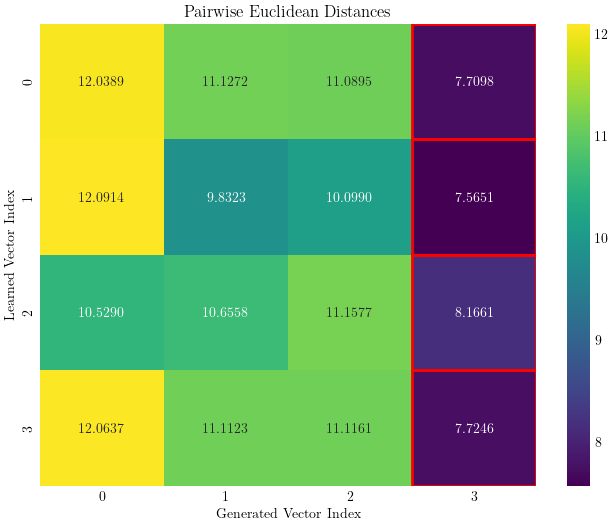

In [31]:
# Set ticks length to zero
plt.rcParams["xtick.minor.size"] = 0
plt.rcParams["ytick.minor.size"] = 0
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0

pairwise_distances = jnp.sqrt(
    jnp.sum((vectors[:, None, :] - vec_nls[None, :, :]) ** 2, axis=-1)
)
min_indices = jnp.argmin(pairwise_distances, axis=1)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(pairwise_distances, annot=True, fmt=".4f", cmap="viridis", cbar=True)

# Highlight the minimum value in each row with a red border
for i, min_idx in enumerate(min_indices):
    ax.add_patch(plt.Rectangle((min_idx, i), 1, 1, fill=False, edgecolor="red", lw=2))

# Add labels and title
plt.xlabel("Generated Vector Index")
plt.ylabel("Learned Vector Index")
plt.title("Pairwise Euclidean Distances")
plt.show()
plt.clf()
plt.close()

plt.rcParams.update(plt.rcParamsDefault)
plt.style.use("science")

[Array(2, dtype=int64), Array(2, dtype=int64), Array(3, dtype=int64), Array(2, dtype=int64)]


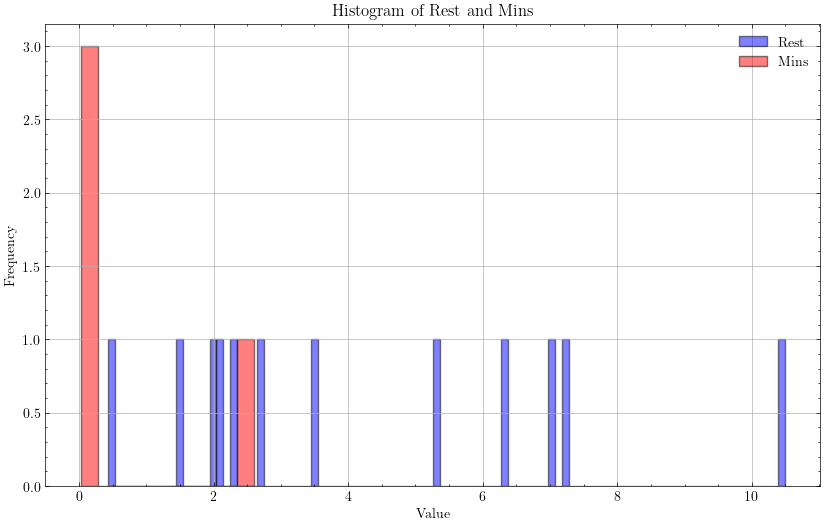

In [32]:
vectors = jnp.concatenate(
    (
        state.params["params"]["CustomActivation_0"]["alpha"],
        state.params["params"]["CustomActivation_0"]["gamma"],
    ),
    axis=0,
).T

rest = []
mins = []
mins_nls = []

for vec in vectors:
    temp = []
    for nls in vec_nls:
        temp.append(jnp.abs(vec @ nls))

    min_value = jnp.min(jnp.array(temp))
    min_index = jnp.argmin(jnp.array(temp))  # Find the index of the minimum value

    mins.append(min_value)
    mins_nls.append(min_index)  # Store the `nls` corresponding to the minimum value

    # Remove the min value and associated nls
    temp.remove(min_value)
    rest.append(temp)

print(mins_nls)

plt.figure(figsize=(10, 6))
plt.hist(
    [item for sublist in rest for item in sublist],
    bins=100,
    edgecolor="black",
    alpha=0.5,
    label="Rest",
    color="blue",
)
plt.hist(mins, bins=10, edgecolor="black", alpha=0.5, label="Mins", color="red")
plt.title("Histogram of Rest and Mins")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
print(vectors)
print(vec_nls)

[[ 0.29768175  0.30408365  0.29437976  0.68938667  0.68960849  0.68917277]
 [-0.28676867 -0.82473031 -0.2588166  -0.07411025 -0.44579355 -0.10156021]
 [-0.30684244 -0.29408872 -0.27093421  0.65837424  0.65826801  0.65807803]
 [-0.17305735  0.7094067  -0.21699679  0.65892752 -0.68583253  0.67326781]]
[[-1.10193656 -1.51553843 -2.28166617  1.37503869 -5.26811309 -9.21461028]
 [-4.39734918  2.24324436 -1.02935378 -6.93446749  6.72467578 -0.60287698]
 [-4.47239829 -3.03186745  4.60982899 -4.69652958 -0.83694919  7.00154973]
 [-1.26942404  0.83381083  4.52596135 -0.33196753  5.30788252 -3.36975958]]


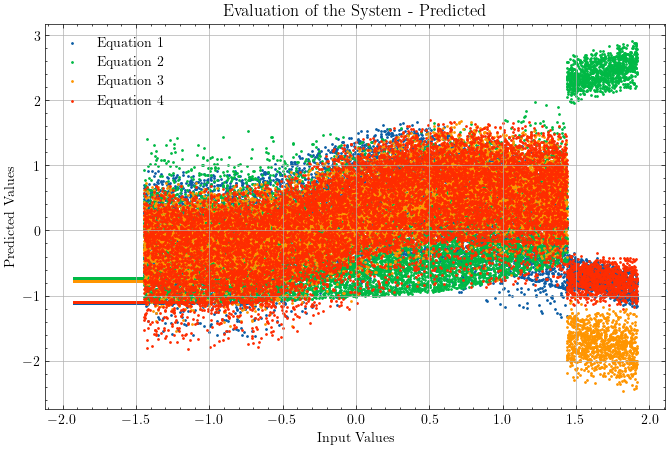

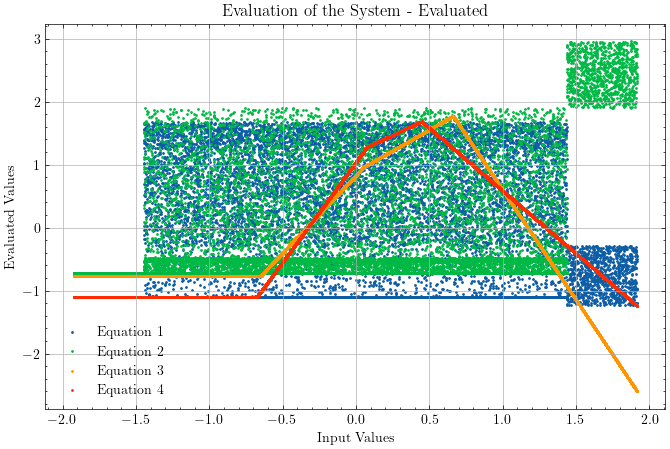

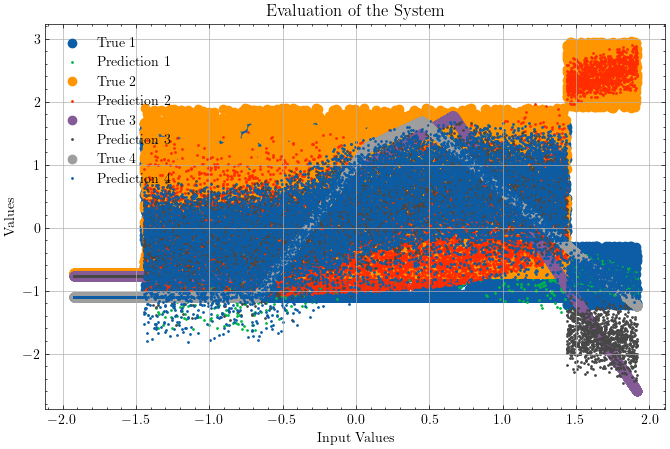

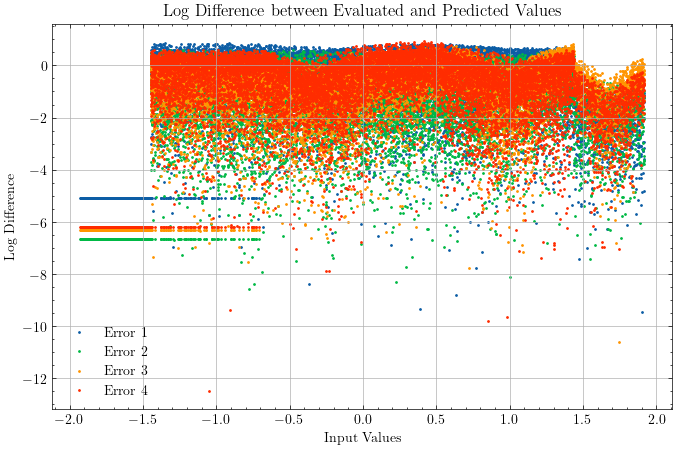

In [34]:
predicted_values = state.apply_fn(state.params, expanded_values)

plt.figure(figsize=(8, 5))
for i in range(config["n_eqs"]):
    plt.scatter(values[:, 0], predicted_values[:, i], label=f"Equation {i+1}", s=1)
plt.xlabel("Input Values")
plt.ylabel("Predicted Values")
plt.title("Evaluation of the System - Predicted")
plt.grid(True)
if config["n_eqs"] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config["n_eqs"]):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f"Equation {i+1}", s=1)
plt.xlabel("Input Values")
plt.ylabel("Evaluated Values")
plt.title("Evaluation of the System - Evaluated")
plt.grid(True)
if config["n_eqs"] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config["n_eqs"]):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f"True {i+1}")
    plt.scatter(values[:, 0], predicted_values[:, i], label=f"Prediction {i+1}", s=1)
plt.xlabel("Input Values")
plt.ylabel("Values")
plt.title("Evaluation of the System")
plt.grid(True)
if config["n_eqs"] < 10:
    plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(config["n_eqs"]):
    plt.scatter(
        values[:, 0],
        jnp.log(jnp.abs(evaluated_values[:, i] - predicted_values[:, i])),
        label=f"Error {i+1}",
        s=1,
    )
plt.xlabel("Input Values")
plt.ylabel("Log Difference")
plt.title("Log Difference between Evaluated and Predicted Values")
plt.grid(True)
if config["n_eqs"] < 10:
    plt.legend()
plt.show()

plt.clf()
plt.close()

In [35]:
print(state.params["params"]["Dense_0"]["kernel"])

[[ 0.7235591   0.51330703 -0.3564513   0.29248998]
 [ 1.0307971  -0.07360492  0.12482438  0.69784737]
 [-0.22700973  0.19536108 -0.6422959  -0.7630849 ]
 [-0.06450161  0.47173735 -1.4023402  -0.15306757]
 [ 0.44804794  0.19162571  0.2916988   0.54279596]
 [ 0.75402975 -0.63617957  0.3705959   0.98433656]
 [-0.39491388  0.15919638  0.20869043  0.15048204]
 [ 0.11797605 -0.35990602 -1.6715864  -0.19891354]
 [ 0.47329462  0.05131428 -0.44454208  0.33654705]
 [ 0.6488392  -0.28392446  0.4052781   0.94481915]
 [-0.421289   -0.36897427 -0.36514482 -0.47907245]
 [-0.35107997  0.21985914 -1.2547572   0.36642092]
 [ 0.17818183 -0.10603408  0.08355043  0.5847139 ]
 [ 1.2914798  -0.33616152  0.36244488  1.1017864 ]
 [-0.67238224  0.34079525  0.25857282 -0.69676906]
 [ 0.26942176  0.02171921 -1.4041753  -0.03832496]]
